# Importing Libraries

In [1]:
import split_data
from dataload.dataload import load_data
from utils.utils import load_checkpoint, build_model, visualize_data, plot_losses, calculate_accuracy, gradcam_visualization
from model.resnet50 import create_model
import torch
from train import train
import torchsummary
%reload_ext autoreload
%autoreload 2

# Training

In [2]:
images_dir = '../../data/UTKFace/images'
base_data_dir = '../../data/UTKFace'
train_split = 0.7
valid_split = 0.2

In [3]:
# Hyperparameters
aug_p = 0.4
batch_size = 64
base_model = 'resnet50'
dropout_p = 0.4
freeze = True
num_layers = 120
learning_rate = 1e-03
unfrozen_learning_rate = 3e-05
epochs = 10

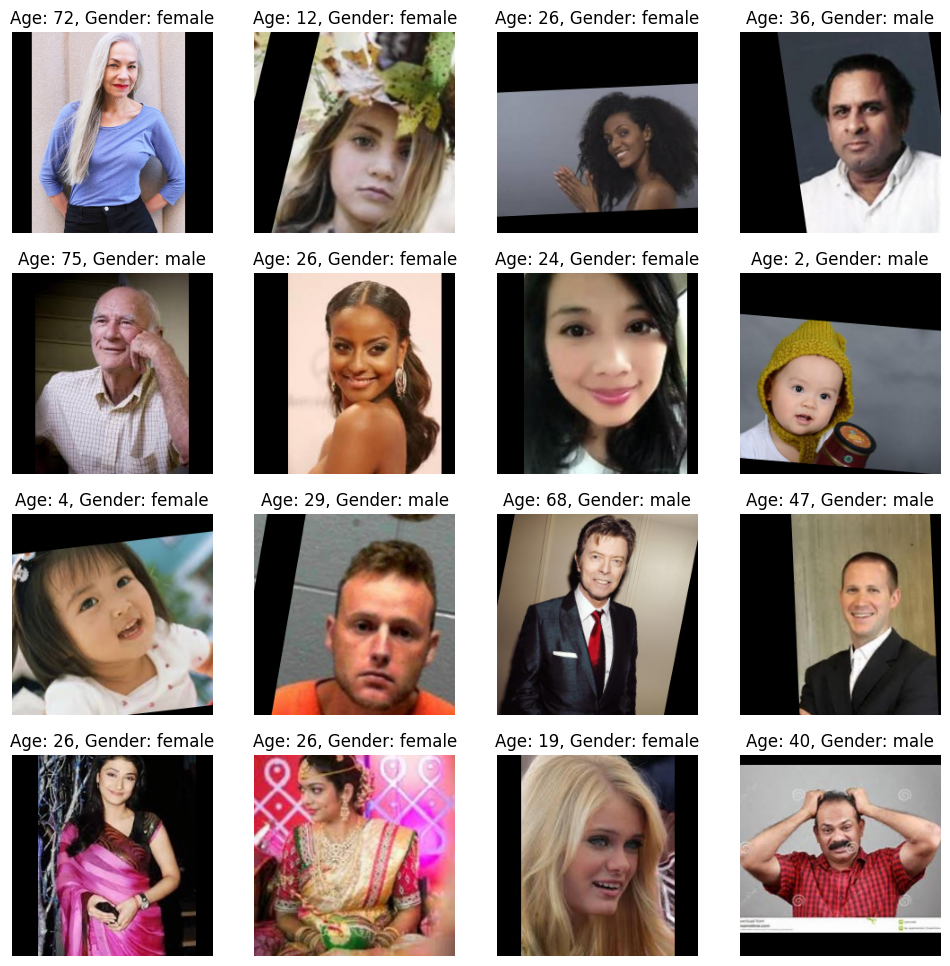

In [4]:
split_data.split(base_data_dir, images_dir, train_split, valid_split)
trainloader, validloader, testloader = load_data(base_data_dir, images_dir, aug_p, batch_size)
visualize_data(trainloader, num_images = 16, figsize=(12, 12))

In [5]:
model = create_model(base_model, freeze, num_layers, dropout_p)
print(torchsummary.summary(model))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (9,408)
|    └─BatchNorm2d: 2-2                  (128)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─Bottleneck: 3-1              (75,008)
|    |    └─Bottleneck: 3-2              (70,400)
|    |    └─Bottleneck: 3-3              (70,400)
|    └─Sequential: 2-6                   --
|    |    └─Bottleneck: 3-4              (379,392)
|    |    └─Bottleneck: 3-5              (280,064)
|    |    └─Bottleneck: 3-6              (280,064)
|    |    └─Bottleneck: 3-7              (280,064)
|    └─Sequential: 2-7                   --
|    |    └─Bottleneck: 3-8              (1,512,448)
|    |    └─Bottleneck: 3-9              (1,117,184)
|    |    └─Bottleneck: 3-10             (1,117,184)
|    |    └─Bottleneck: 3-11             1,117,184
|    |    └─Bottleneck: 3-1

In [ ]:
criterion_mae, criterion_bce, optimizer, scheduler = build_model(model, epochs, learning_rate, True)
model, train_bce_losses, train_mae_losses, valid_bce_losses, valid_mae_losses, \
best_loss = train(trainloader, validloader, model, criterion_mae, criterion_bce, optimizer, epochs, scheduler = scheduler)

In [7]:
# Since Load Checkpoint returns none also, model object have two parts
print("Validation")
calculate_accuracy(validloader, model[0])
print("Training")
calculate_accuracy(trainloader, model[0])

Validation
Final Accuracy: 93.170
Training
Final Accuracy: 97.669


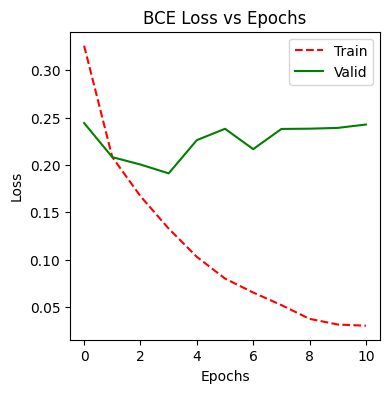

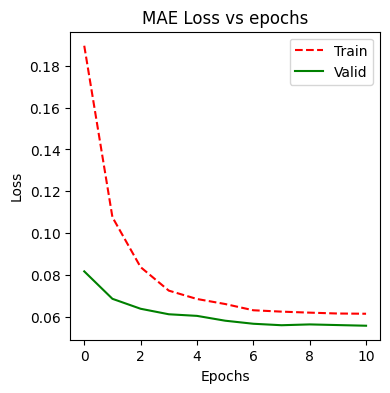

In [8]:
plot_losses(train_bce_losses, valid_bce_losses, "BCE Loss vs Epochs", figsize = (4,4))
plot_losses(train_mae_losses, valid_mae_losses, "MAE Loss vs epochs", figsize = (4,4))

In [ ]:
print(f'{"*"*10} Unfreezing {"*"*10}')
# Unfreeze
model = create_model(base_model, freeze = False, dropout_p=dropout_p)
model, _ = load_checkpoint(model, file_path='saved_models/multi_task.pt')
criterion_mae, criterion_bce, optimizer, scheduler = build_model(model, epochs, unfrozen_learning_rate, True)
model, train_bce_losses, train_mae_losses, valid_bce_losses, valid_mae_losses, \
best_loss = train(trainloader, validloader, model, criterion_mae, criterion_bce, optimizer, epochs, best_loss, scheduler)

In [10]:
# Since Load Checkpoint returns none also, model object have two parts
print("Validation")
calculate_accuracy(validloader, model[0])
print("Training")
calculate_accuracy(trainloader, model[0])

Validation
Final Accuracy: 93.191
Training
Final Accuracy: 98.339


# Testing on testloader

In [5]:
model = create_model(base_model, freeze = False, dropout_p = dropout_p)
model, _ = load_checkpoint(model, file_path = 'saved_models/multi_task.pt')

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print("Test Set")
calculate_accuracy(testloader, model)

Test Set
Final Accuracy: 93.773


Almost similar to validation dataset

# Gradcam visualization

In [7]:
for param in model.feature_extractor.parameters():
    param.requires_grad = True

In [10]:
imgs, _, _ = next(iter(trainloader))

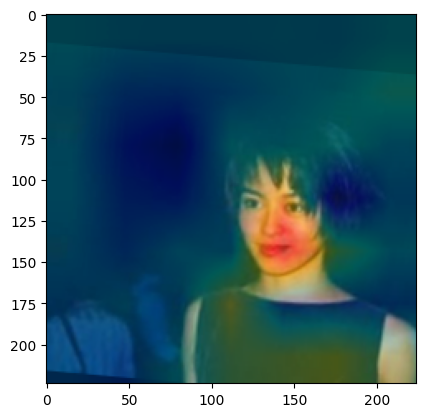

In [14]:
idx = 0
img = imgs[idx]
gradcam_visualization(img, model)

torch.Size([3, 224, 224])


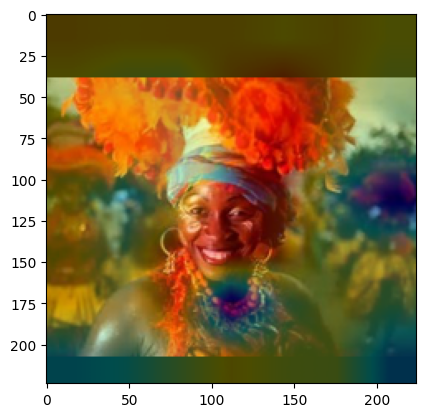

In [15]:
idx = 1
img = imgs[idx]
print(img.shape)
gradcam_visualization(img, model)

torch.Size([3, 224, 224])


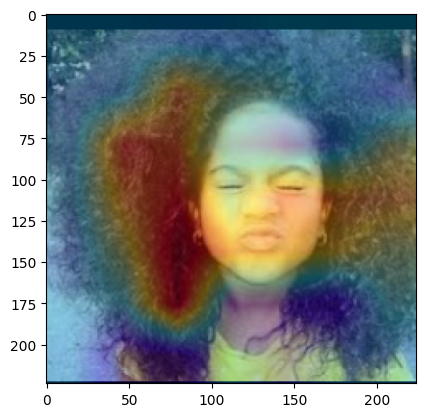

In [16]:
idx = 2
img = imgs[idx]
print(img.shape)
gradcam_visualization(img, model)